In [14]:
import xarray as xr
import phase_composite_wave_ccew as pc  # 将侧边代码保存为同名 .py 后导入
import sys
sys.path.append(r'M:\公众号\ipynb_汇总\func')  # 添加模块路径
import wave_kf_filter as wkf
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import cmocean
from typing import Tuple, Optional, Dict, List
import matplotlib.colors as mcolors
import pandas as pd
from scipy import stats
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


## kelvin波信号滤波

In [12]:

# 读取降水 (time, lat, lon)
ds = xr.open_dataset('I:/olr.day.mean.nc').olr.sel(
        time=slice('1979-01-01', '2022-12-31'),
        lat=slice(15, -15)).sortby('lat')
    

wave_filter = wkf.WaveFilter()
# 提取Kelvin波动信号
kelvin_filtered = wave_filter.extract_wave_signal(ds, wave_name='kelvin', use_parallel=True)



### 标准差空间分布图

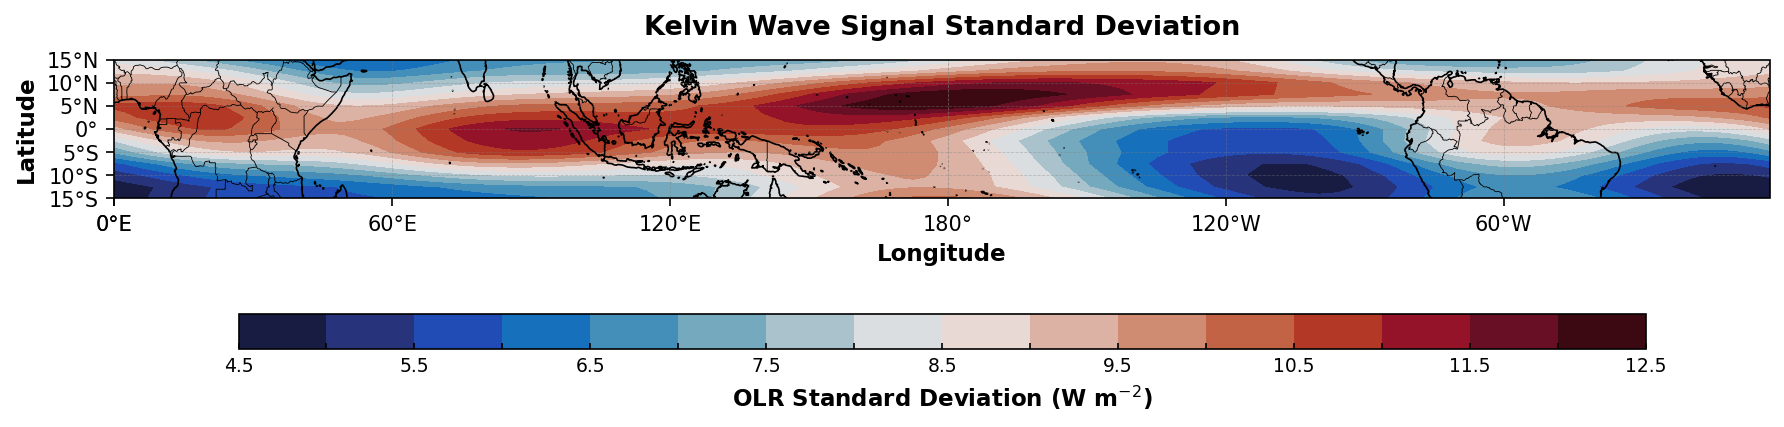

In [15]:
def plot_kelvin_std(data, cmap=cmocean.cm.balance, levels=20, lon_step=60, lat_step=5):
    """
    绘制 Kelvin 波标准差图（全球 0-360，经纬度 -15~15）。

    Parameters
    ----------
    data : xarray.DataArray
        输入数据 (需要有 lat, lon 维度)。
    cmap : str
        颜色映射，默认 'cmocean.cm.balance'。
    levels : int
        等值线层数。
    lon_step : int
        经度刻度间隔。
    lat_step : int
        纬度刻度间隔。
    """
    fig = plt.figure(figsize=(12, 8), dpi=150)
    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))

    # 数据绘制
    im = data.std('time').plot.contourf(
        ax=ax,
        cmap=cmap,
        levels=levels,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )

    # 自动刻度设置
    xticks = range(0, 361, 60)  # 经度间隔 60°
    yticks = range(-15, 16, 5)  # 纬度间隔 5°
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    # 自动格式化标签
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # 刻度样式
    ax.tick_params(axis='both', which='major', labelsize=10, length=4, width=0.8)
    ax.set_xlabel('Longitude', fontsize=11, fontweight='bold')
    ax.set_ylabel('Latitude', fontsize=11, fontweight='bold')
    # 地图要素
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='k', linewidth=0.4)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.4, color='gray', alpha=0.4)

    # 颜色条
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad = 0.1, aspect=40, shrink=0.85)
    cbar.set_label('OLR Standard Deviation (W m$^{-2}$)', fontsize=11, fontweight='bold')
    cbar.ax.tick_params(which = 'both',labelsize=9, width=0.8, length=3, direction='in', color='black')

    # 标题
    ax.set_title('Kelvin Wave Signal Standard Deviation', fontsize=13, weight='bold', pad=12)
    plt.tight_layout()
    plt.show()
plot_kelvin_std(kelvin_filtered)

## 封装函数

In [30]:


# =================================== 辅助函数 ==========================================
def _std_dim_names(da: xr.DataArray) -> Tuple[str, str, str]:
    """自动识别时间、纬度、经度维度名称"""
    dims = list(da.dims)
    t = next((d for d in dims if 'time' in d.lower()), dims[0])
    lat = next((d for d in dims if d.lower().startswith(('lat', 'y'))), dims[1])
    lon = next((d for d in dims if d.lower().startswith(('lon', 'x'))), dims[2])
    return t, lat, lon

def _global_std_norm(field: xr.DataArray, time_dim: str, lon_dim: str) -> xr.DataArray:
    """对数据场进行全局标准化"""
    sigma = field.std(dim=(time_dim, lon_dim), skipna=True)
    return field / sigma

def _bin_angles(angle: xr.DataArray, n_bins: int = 8) -> xr.DataArray:
    """将连续的角度值分箱为离散的相位指数"""
    edges = np.linspace(0, 2 * np.pi, n_bins + 1)
    phase = np.digitize(angle, edges, right=False)
    phase = ((phase - 1) % n_bins) + 1
    return xr.DataArray(phase, coords=angle.coords, dims=angle.dims, name='phase')

def _generate_phase_colors(n_phases: int) -> list:
    """根据相位数量自动生成从冷色到暖色的渐变颜色列表"""
    if n_phases <= 8:
        # 从蓝色（负值）到红色（正值）的渐变
        import matplotlib.cm as cm
        cmap = cm.RdYlBu_r  # 反转的红-黄-蓝色图，从蓝到红
        return [cmap(i / (n_phases - 1)) for i in range(n_phases)]
    else:
        cmap = plt.cm.RdYlBu_r
        return [cmap(i / (n_phases - 1)) for i in range(n_phases)]

def reorder_phases_by_angular_position(
    P_norm: xr.DataArray, 
    dP_norm: xr.DataArray,
    amplitude: xr.DataArray,
    angle: xr.DataArray,
    strong_mask: xr.DataArray,
    n_phases: int = 8,
    start_angle_deg: float = 0.0
) -> Tuple[xr.DataArray, Dict, xr.DataArray]:
    """
    Phase 1: Mean P最大且Mean dP最接近0（最抑制）
    Phase N/2+1: Mean P最小且Mean dP最接近0（最活跃）
    其余相位按角度逆时针排序，编号连续，体现增强-衰减物理过程
    """
    initial_phases = _bin_angles(angle, n_phases)
    phase_stats = {}
    for i in range(1, n_phases + 1):
        phase_mask = (initial_phases == i) & strong_mask
        if np.any(phase_mask):
            mean_P = float(P_norm.where(phase_mask).mean().values)
            mean_dP = float(dP_norm.where(phase_mask).mean().values)
            mean_amp = float(amplitude.where(phase_mask).mean().values)
            phase_angles = angle.where(phase_mask)
            complex_angles = np.exp(1j * phase_angles.values.ravel())
            complex_angles = complex_angles[~np.isnan(complex_angles)]
            if len(complex_angles) > 0:
                mean_angle = float(np.angle(np.mean(complex_angles)) % (2 * np.pi))
            else:
                mean_angle = (i - 0.5) * 2 * np.pi / n_phases
            phase_count = int(phase_mask.sum().values)
        else:
            mean_P = mean_dP = mean_amp = 0.0
            mean_angle = (i - 0.5) * 2 * np.pi / n_phases
            phase_count = 0
        phase_stats[i] = {
            'original_id': i,
            'mean_P': mean_P,
            'mean_dP': mean_dP,
            'mean_amplitude': mean_amp,
            'mean_angle': mean_angle,
            'count': phase_count
        }

    valid_ids = [i for i in phase_stats if phase_stats[i]['count'] > 0]
    # 先找Mean dP最接近0的前3个
    sorted_by_dp = sorted(valid_ids, key=lambda i: abs(phase_stats[i]['mean_dP']))
    dp_candidates = sorted_by_dp[:min(3, len(sorted_by_dp))]
    # Phase 1: 在dp_candidates中P最大
    suppressed_id = max(dp_candidates, key=lambda i: phase_stats[i]['mean_P'])
    # Phase N/2+1: 在dp_candidates中P最小
    active_id = min(dp_candidates, key=lambda i: phase_stats[i]['mean_P'])

    # 按角度逆时针排序所有有效相位
    sorted_phases = sorted(valid_ids, key=lambda i: phase_stats[i]['mean_angle'])
    # 以Phase 1为起点编号
    idx_suppressed = sorted_phases.index(suppressed_id)
    reordered = sorted_phases[idx_suppressed:] + sorted_phases[:idx_suppressed]

    # 新编号映射
    active_target_position = n_phases // 2 + 1
    new_phase_mapping = {}
    new_phase_mapping[suppressed_id] = 1
    new_phase_mapping[active_id] = active_target_position
    # 其余编号
    remaining_originals = [i for i in reordered if i not in [suppressed_id, active_id]]
    remaining_new_ids = [i for i in range(1, n_phases + 1) if i not in [1, active_target_position]]
    for i, orig in enumerate(remaining_originals):
        if i < len(remaining_new_ids):
            new_phase_mapping[orig] = remaining_new_ids[i]
    # 若有效相位数 < n_phases，补全剩余编号给无效相位
    used_original = set(new_phase_mapping.keys())
    unused_original = [i for i in range(1, n_phases + 1) if i not in used_original]
    used_new = set(new_phase_mapping.values())
    unused_new = [i for i in range(1, n_phases + 1) if i not in used_new]
    for orig, new in zip(unused_original, unused_new):
        new_phase_mapping[orig] = new

    # 应用映射
    reordered_phases_data = initial_phases.copy()
    for orig, new in new_phase_mapping.items():
        reordered_phases_data = reordered_phases_data.where(initial_phases != orig, new)

    # 角度整体旋转，使phase1的平均角度对齐start_angle_deg
    mean_angle_phase1 = phase_stats[suppressed_id]['mean_angle']
    target_angle = np.deg2rad(start_angle_deg) % (2 * np.pi)
    angle_shift = (target_angle - mean_angle_phase1) % (2 * np.pi)
    rotated_angle = (angle + angle_shift) % (2 * np.pi)

    # 更新统计信息
    reordered_stats = {}
    for new_id in range(1, n_phases + 1):
        phase_mask = (reordered_phases_data == new_id) & strong_mask
        if np.any(phase_mask):
            mean_P = float(P_norm.where(phase_mask).mean().values)
            mean_dP = float(dP_norm.where(phase_mask).mean().values)
            mean_amp = float(amplitude.where(phase_mask).mean().values)
            phase_angles = rotated_angle.where(reordered_phases_data == new_id)
            complex_angles = np.exp(1j * phase_angles.values.ravel())
            complex_angles = complex_angles[~np.isnan(complex_angles)]
            if len(complex_angles) > 0:
                mean_angle = float(np.angle(np.mean(complex_angles)) % (2 * np.pi))
            else:
                mean_angle = 0.0
            phase_count = int(phase_mask.sum().values)
        else:
            mean_P = mean_dP = mean_amp = mean_angle = 0.0
            phase_count = 0
        if new_id == 1:
            phase_type = "Most Suppressed"
        elif new_id == active_target_position:
            phase_type = "Most Active"
        elif new_id < active_target_position:
            phase_type = "Developing"
        else:
            phase_type = "Decaying"
        reordered_stats[new_id] = {
            'phase_id': new_id,
            'mean_P': mean_P,
            'mean_dP': mean_dP,
            'mean_amplitude': mean_amp,
            'mean_angle': mean_angle,
            'count': phase_count,
            'phase_type': phase_type
        }

    phase_info = {
        'mapping': new_phase_mapping,
        'stats': reordered_stats,
        'ordering_method': 'suppressed-active',
        'start_angle_deg': start_angle_deg,
        'phase1_original': suppressed_id,
        'most_active_phase': active_target_position,
        'angle_shift': angle_shift
    }
    return reordered_phases_data, phase_info, rotated_angle

def plot_kelvin_wave_core_analysis(
    dataset: xr.Dataset,
    start_angle_deg: float = 0.0
) -> Tuple[plt.Figure, np.ndarray]:
    """
    通过旋转所有散点，使相位1的中心点显示在 start_angle_deg 指定的方向
    """
    phases = dataset['phase_index'].values.ravel()
    P_values = dataset['P_norm'].values.ravel()
    dP_values = dataset['dP_norm'].values.ravel()
    strong = dataset['strong_mask'].values.ravel()
    n_phases = dataset.attrs.get('n_phases', 8)
    phase_info = dataset.attrs.get('phase_info', {})
    colors = _generate_phase_colors(n_phases)

    # 计算相位1中心点的极角
    mask_phase1 = strong & (phases == 1)
    if np.any(mask_phase1):
        mean_P1 = np.mean(P_values[mask_phase1])
        mean_dP1 = np.mean(dP_values[mask_phase1])
        current_angle = np.arctan2(mean_dP1, mean_P1) % (2 * np.pi)
    else:
        current_angle = 0.0
    target_angle = np.deg2rad(start_angle_deg) % (2 * np.pi)
    rotate_angle = (target_angle - current_angle) % (2 * np.pi)

    # 对所有点进行旋转
    P_rot = P_values * np.cos(rotate_angle) - dP_values * np.sin(rotate_angle)
    dP_rot = P_values * np.sin(rotate_angle) + dP_values * np.cos(rotate_angle)

    fig = plt.figure(figsize=(16, 12))
    ax1 = fig.add_subplot(2, 2, 1)

    # 绘制弱事件背景
    ax1.scatter(P_rot[~strong], dP_rot[~strong], s=8, alpha=0.2, 
               color='lightgray', label='Weak Events', zorder=1)

    # 按相位编号顺序绘制中心点和连接线
    phase_centers_x = []
    phase_centers_y = []
    phase_center_angles = []
    phase_center_ids = []
    for i in range(1, n_phases + 1):
        mask = strong & (phases == i)
        if np.any(mask):
            ax1.scatter(P_rot[mask], dP_rot[mask], s=25, alpha=0.8, 
                       color=colors[i-1], label=f'Phase {i}', zorder=2, 
                       edgecolors='white', linewidth=0.5)
            mean_P = np.mean(P_rot[mask])
            mean_dP = np.mean(dP_rot[mask])
            mean_angle = np.arctan2(mean_dP, mean_P) % (2 * np.pi)
        else:
            mean_P = np.nan
            mean_dP = np.nan
            mean_angle = np.nan
        phase_centers_x.append(mean_P)
        phase_centers_y.append(mean_dP)
        phase_center_angles.append(mean_angle)
        phase_center_ids.append(i)
        if np.any(mask):
            ax1.plot(mean_P, mean_dP, 'o', color=colors[i-1], markersize=12, 
                    markeredgecolor='black', markeredgewidth=2, zorder=4)
            ax1.text(mean_P, mean_dP, f'{i}', ha='center', va='center', 
                    fontsize=10, fontweight='bold', color='white', zorder=5)

    # 按平均角度逆时针排序后绘制连线和箭头
    valid = [(i, phase_centers_x[i], phase_centers_y[i], phase_center_angles[i]) 
             for i in range(n_phases) 
             if not np.isnan(phase_centers_x[i]) and not np.isnan(phase_centers_y[i])]
    # 按角度从小到大排序（逆时针）
    valid_sorted = sorted(valid, key=lambda x: x[3])
    if len(valid_sorted) > 1:
        for idx in range(len(valid_sorted)):
            i, x1, y1, _ = valid_sorted[idx]
            j, x2, y2, _ = valid_sorted[(idx + 1) % len(valid_sorted)]
            ax1.plot([x1, x2], [y1, y2], 'k-', linewidth=2, alpha=0.6, zorder=3)
            dx = x2 - x1
            dy = y2 - y1
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            ax1.annotate('', xy=(mid_x + 0.1*dx, mid_y + 0.1*dy),
                         xytext=(mid_x - 0.1*dx, mid_y - 0.1*dy),
                         arrowprops=dict(arrowstyle='->', color='black', lw=1.5, alpha=0.7),
                         zorder=4)

    # 角度标记位置旋转
    angle_offset = np.deg2rad(start_angle_deg)
    r = 3.5
    ax1.text(r * np.cos(angle_offset), r * np.sin(angle_offset), f'{int(start_angle_deg)}°',
             ha='center', va='center', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    ax1.text(r * np.cos(angle_offset + np.pi/2), r * np.sin(angle_offset + np.pi/2), 
             f'{int((start_angle_deg+90)%360)}°', ha='center', va='center', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    ax1.text(r * np.cos(angle_offset + np.pi), r * np.sin(angle_offset + np.pi), 
             f'{int((start_angle_deg+180)%360)}°', ha='center', va='center', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    ax1.text(r * np.cos(angle_offset + 3*np.pi/2), r * np.sin(angle_offset + 3*np.pi/2), 
             f'{int((start_angle_deg+270)%360)}°', ha='center', va='center', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    ax1.set_xlabel('Normalized P (OLR Anomaly)', fontsize=11)
    ax1.set_ylabel('Normalized dP/dt (Time Derivative)', fontsize=11)
    ax1.set_title('Phase Space', fontsize=12, fontweight='bold')
    ax1.set_xlim(-6, 6)
    ax1.set_ylim(-6, 6)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    ax1.set_aspect('equal')
    
    # 2. 相位演化曲线图 (右上) - 按物理演化顺序显示(从最活跃相位开始)
    ax2 = fig.add_subplot(2, 2, 2)
    
    # 获取最活跃相位编号
    active_phase = phase_info.get('most_active_phase', n_phases//2+1)
    
    # 构建物理演化顺序：从最活跃相位开始，然后是后续相位，最后是前面的相位
    evolution_order = []
    for i in range(active_phase, n_phases + 1):
        evolution_order.append(i)
    for i in range(1, active_phase):
        evolution_order.append(i)
    
    # 收集按演化顺序的相位数据
    evolution_positions = []  # x轴位置
    evolution_means = []
    evolution_stds = []
    evolution_phase_ids = []
    
    for pos, phase_id in enumerate(evolution_order):
        mask = (phases == phase_id) & strong
        if np.any(mask):
            phase_P = P_values[mask]
            evolution_positions.append(pos)
            evolution_means.append(np.mean(phase_P))
            evolution_stds.append(np.std(phase_P))
            evolution_phase_ids.append(phase_id)
    
    # 绘制演化曲线
    if len(evolution_positions) > 0:
        ax2.plot(evolution_positions, evolution_means, 'o-', linewidth=3, markersize=8, 
                color='darkgreen', markerfacecolor='white', markeredgewidth=2,
                label='Physical Evolution')
        
        # 添加误差带
        evolution_means_arr = np.array(evolution_means)
        evolution_stds_arr = np.array(evolution_stds)
        ax2.fill_between(evolution_positions, 
                        evolution_means_arr - evolution_stds_arr, 
                        evolution_means_arr + evolution_stds_arr,
                        alpha=0.3, color='green', label='±1 Standard Deviation')
        
        # 标注各相位点
        for pos, phase_id, mean_val in zip(evolution_positions, evolution_phase_ids, evolution_means):
            color = colors[phase_id-1]
            ax2.plot(pos, mean_val, 'o', color=color, markersize=10, 
                    markeredgecolor='black', markeredgewidth=1.5, zorder=3)
            ax2.text(pos, mean_val + 0.2, f'P{phase_id}', ha='center', va='bottom', 
                    fontsize=9, fontweight='bold', 
                    bbox=dict(boxstyle='round,pad=0.2', facecolor=color, alpha=0.7))
    
    # 标注关键节点
    if len(evolution_positions) > 0:
        # 标注最活跃相位(起点/峰值)
        ax2.annotate('Peak Convection\n(Most Active)', 
                    xy=(0, evolution_means[0]),
                    xytext=(1., evolution_means[0] + 0.8), 
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='lightcoral', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    fontsize=9, ha='center')
        
        # 如果最抑制相位在演化序列中，标注它
        if 1 in evolution_phase_ids:
            suppressed_idx = evolution_phase_ids.index(1)
            ax2.annotate('Most Suppressed', 
                        xy=(suppressed_idx, evolution_means[suppressed_idx]),
                        xytext=(suppressed_idx , evolution_means[suppressed_idx] - 0.9), 
                        bbox=dict(boxstyle='round,pad=0.4', facecolor='lightblue', alpha=0.8),
                        arrowprops=dict(arrowstyle='->', color='blue'),
                        fontsize=9, ha='center')
    
    # 设置x轴标签为演化顺序的相位编号
    if len(evolution_positions) > 0:
        ax2.set_xticks(evolution_positions)
        ax2.set_xticklabels([f'P{pid}' for pid in evolution_phase_ids])
        ax2.set_xlim(-0.5, len(evolution_positions) - 0.5)
    
    ax2.axhline(0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    ax2.set_xlabel('Physical Evolution Sequence', fontsize=11)
    ax2.set_ylabel('OLR Anomaly (normalized)', fontsize=11)
    ax2.set_title('Kelvin Wave Physical Evolution\n(Peak → Decay → Suppression → Development)', 
                  fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right', fontsize=9)
    
    # 3. 强度随相位变化图 (左下) - 保持原样
    ax3 = fig.add_subplot(2, 2, 3)
    
    phase_nums_all = list(range(1, n_phases + 1))
    phase_means_all = []
    phase_stds_all = []
    
    for i in range(1, n_phases + 1):
        mask = (phases == i) & strong
        if np.any(mask):
            phase_P = P_values[mask]
            phase_means_all.append(np.mean(phase_P))
            phase_stds_all.append(np.std(phase_P))
        else:
            phase_means_all.append(np.nan)
            phase_stds_all.append(np.nan)
    
    # 绘制柱状图
    bars = ax3.bar(phase_nums_all, phase_means_all, color=colors, alpha=0.7, 
                   edgecolor='black', linewidth=1, width=0.6)
    
    # 添加误差棒
    valid_indices = [i for i, val in enumerate(phase_means_all) if not np.isnan(val)]
    if valid_indices:
        valid_means = [phase_means_all[i] for i in valid_indices]
        valid_stds = [phase_stds_all[i] for i in valid_indices]
        valid_nums = [phase_nums_all[i] for i in valid_indices]
        
        ax3.errorbar(valid_nums, valid_means, yerr=valid_stds, 
                    fmt='none', capsize=4, capthick=1.5, color='black', alpha=0.8)
    
    ax3.axhline(0, color='black', linestyle='-', alpha=0.6, linewidth=1.5)
    ax3.set_xlabel('Phase Index', fontsize=11)
    ax3.set_ylabel('OLR Anomaly (normalized)', fontsize=11)
    ax3.set_title('Phase Intensity Statistics', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. 相位天数占比分布图 (右下) - 保持原样
    ax4 = fig.add_subplot(2, 2, 4)
    
    total_strong_days = np.sum(strong)
    phase_days = []
    phase_percentages = []
    
    for i in range(1, n_phases + 1):
        mask = (phases == i) & strong
        days = np.sum(mask)
        percentage = (days / total_strong_days * 100) if total_strong_days > 0 else 0
        phase_days.append(days)
        phase_percentages.append(percentage)
    
    bars = ax4.bar(phase_nums_all, phase_percentages, color=colors, alpha=0.8, 
                  edgecolor='black', linewidth=1.2, width=0.7)
    
    for i, (bar, days, pct) in enumerate(zip(bars, phase_days, phase_percentages)):
        height = bar.get_height()
        if height > 0:
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                    f'{days}\n({pct:.1f}%)', ha='center', va='bottom', 
                    fontsize=9, fontweight='bold')
    
    avg_percentage = 100 / n_phases
    ax4.axhline(avg_percentage, color='red', linestyle='--', alpha=0.8, linewidth=2,
                label=f'Expected ({avg_percentage:.1f}%)')
    
    ax4.set_xlabel('Phase Index', fontsize=11)
    ax4.set_ylabel('Percentage of Strong Events (%)', fontsize=11)
    ax4.set_title('Phase Frequency Distribution', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_ylim(0, max(phase_percentages) * 1.15)
    ax4.legend(loc='upper right')
    
    plt.suptitle('Kelvin Wave Analysis: Enhancement-Decay Cycle', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    
    return fig, (ax1, ax2, ax3, ax4)

def print_angle_phase_mapping(dataset: xr.Dataset):
    """打印角度-相位映射关系，用于调试"""
    phases = dataset['phase_index'].values.ravel()
    angles = dataset['angle'].values.ravel()
    strong = dataset['strong_mask'].values.ravel()
    n_phases = dataset.attrs.get('n_phases', 8)
    phase_info = dataset.attrs.get('phase_info', {})
    
    print(f"\n=== 最终角度-相位映射关系 ===")
    print(f"排序方法: {phase_info.get('ordering_method', 'unknown')}")
    print(f"起始角度: {phase_info.get('start_angle_deg', 'N/A'):.1f}°")
    
    angle_phase_pairs = []
    for i in range(1, n_phases + 1):
        mask = strong & (phases == i)
        if np.any(mask):
            phase_angles = angles[mask]
            mean_angle = np.mean(phase_angles)
            angle_range = (np.min(phase_angles), np.max(phase_angles))
            angle_phase_pairs.append((i, mean_angle, angle_range))
    
    # 按相位编号排序显示
    angle_phase_pairs.sort(key=lambda x: x[0])
    
    print("相位按逆时针角度排序:")
    for phase_id, mean_angle, angle_range in angle_phase_pairs:
        print(f"Phase {phase_id}: 平均角度 = {mean_angle:.3f} rad ({np.degrees(mean_angle):.1f}°), "
              f"范围 = {angle_range[0]:.3f}-{angle_range[1]:.3f} rad")

# ================ Kelvin 波相位分析 =================
def create_kelvin_phase_space(
    ds: xr.DataArray,
    wave_filter: wkf.WaveFilter,
    invert_sign: bool = False,  # 保持OLR原始物理意义
    n_phase: int = 8,
    strong_thresh: float = 1.0,
    start_angle_deg: float = 0.0  # 仅用于显示
) -> xr.Dataset:
    """创建Kelvin波相位空间分析（排序自动，显示角度可控）"""
    kelvin_filtered = wave_filter.extract_wave_signal(ds, wave_name='kelvin', use_parallel=True)
    time_dim, lat_dim, lon_dim = _std_dim_names(kelvin_filtered)
    
    # 纬度平均
    kelvin_filtered_lat = kelvin_filtered.mean(dim=lat_dim, skipna=True)
    
    # 保持OLR的原始物理意义：高值=少云/弱对流，低值=多云/强对流
    if invert_sign:  # 如果需要转换符号
        kelvin_filtered_lat = -kelvin_filtered_lat

    # 时间导数
    tend = kelvin_filtered_lat.differentiate('time', datetime_unit='s') 
    tend = tend.interp({time_dim: kelvin_filtered_lat[time_dim]})

    # 全局标准化
    P_norm = _global_std_norm(kelvin_filtered_lat, time_dim, lon_dim)
    dP_norm = _global_std_norm(tend, time_dim, lon_dim)
    
    # 幅度 & 相位
    amp = np.sqrt(P_norm**2 + dP_norm**2)
    angle = np.mod(np.arctan2(dP_norm, P_norm), 2 * np.pi)
    strong = amp >= strong_thresh
    
    # 使用优化的角度位置排序
    phase_bins, phase_info, rotated_angle = reorder_phases_by_angular_position(
        P_norm, dP_norm, amp, angle, strong, n_phase, start_angle_deg=start_angle_deg
    )

    out = xr.Dataset(
        data_vars={
            'P_norm': P_norm,
            'dP_norm': dP_norm,
            'amplitude': amp,
            'angle': rotated_angle,  # 用旋转后的角度
            'strong_mask': strong,
            'phase_index': phase_bins
        },
        attrs={
            'description': 'Kelvin wave phase & amplitude analysis (optimized angular ordering)',
            'n_phases': n_phase,
            'strong_threshold': strong_thresh,
            'phase_info': phase_info
        }
    )
    return out

def print_phase_summary(dataset: xr.Dataset):
    """打印相位排序摘要"""
    phase_info = dataset.attrs.get('phase_info', {})
    n_phases = dataset.attrs.get('n_phases', 8)
    
    print(f"\n{'='*75}")
    print(f"    KELVIN WAVE ANGULAR POSITION ANALYSIS ({n_phases} phases)")
    print(f"{'='*75}")
    print(f"相位排序基于角度位置:")
    print(f"Phase 1: 起始于{phase_info.get('start_angle_deg', 'N/A'):.1f}° (右侧中间)")
    print(f"排序方式: 逆时针角度排列")
    print(f"强事件阈值: {dataset.attrs.get('strong_threshold', 2.0)}σ")
    
    if 'stats' in phase_info:
        print(f"\n{'Phase':<6} {'Quadrant':<15} {'Mean P':<8} {'Mean dP':<8} {'Angle':<8} {'Count':<6} {'%':<6}")
        print("-" * 85)
        
        total_strong = sum(stats.get('count', 0) for stats in phase_info['stats'].values())
        
        for phase_id in range(1, n_phases + 1):
            stats = phase_info['stats'].get(phase_id, {})
            count = stats.get('count', 0)
            percentage = (count / total_strong * 100) if total_strong > 0 else 0
            mean_angle_deg = np.degrees(stats.get('mean_angle', 0)) % 360
            
            print(f"{phase_id:<6} {stats.get('phase_type', 'N/A'):<15} "
                  f"{stats.get('mean_P', 0):<8.2f} {stats.get('mean_dP', 0):<8.2f} "
                  f"{mean_angle_deg:<8.1f} {count:<6} {percentage:<6.1f}")
        
        print(f"\n总强事件数: {total_strong}")
        print(f"注：P值为标准化OLR异常（负值=强对流，正值=对流抑制）")
        print(f"    相位按逆时针方向从右上角开始排列")
    print(f"{'='*75}")



## 相位合成

Loading data...
Calculating phase and amplitude with 8 phases...

    KELVIN WAVE ANGULAR POSITION ANALYSIS (8 phases)
相位排序基于角度位置:
Phase 1: 起始于0.0° (右侧中间)
排序方式: 逆时针角度排列
强事件阈值: 1.0σ

Phase  Quadrant        Mean P   Mean dP  Angle    Count  %     
-------------------------------------------------------------------------------------
1      Most Suppressed 1.50     -0.61    360.0    43793  12.8  
2      Developing      1.50     0.61     44.5     43671  12.8  
3      Developing      0.63     1.54     89.6     42428  12.4  
4      Developing      -0.65    1.57     134.6    42781  12.5  
5      Most Active     -1.58    -0.65    224.7    42301  12.4  
6      Decaying        -1.58    0.66     179.7    42427  12.4  
7      Decaying        -0.65    -1.57    269.7    42600  12.4  
8      Decaying        0.63     -1.53    314.8    42237  12.3  

总强事件数: 342238
注：P值为标准化OLR异常（负值=强对流，正值=对流抑制）
    相位按逆时针方向从右上角开始排列

=== 最终角度-相位映射关系 ===
排序方法: suppressed-active
起始角度: 0.0°
相位按逆时针角度排序:
Phase 1: 平均角度 = 3.125 

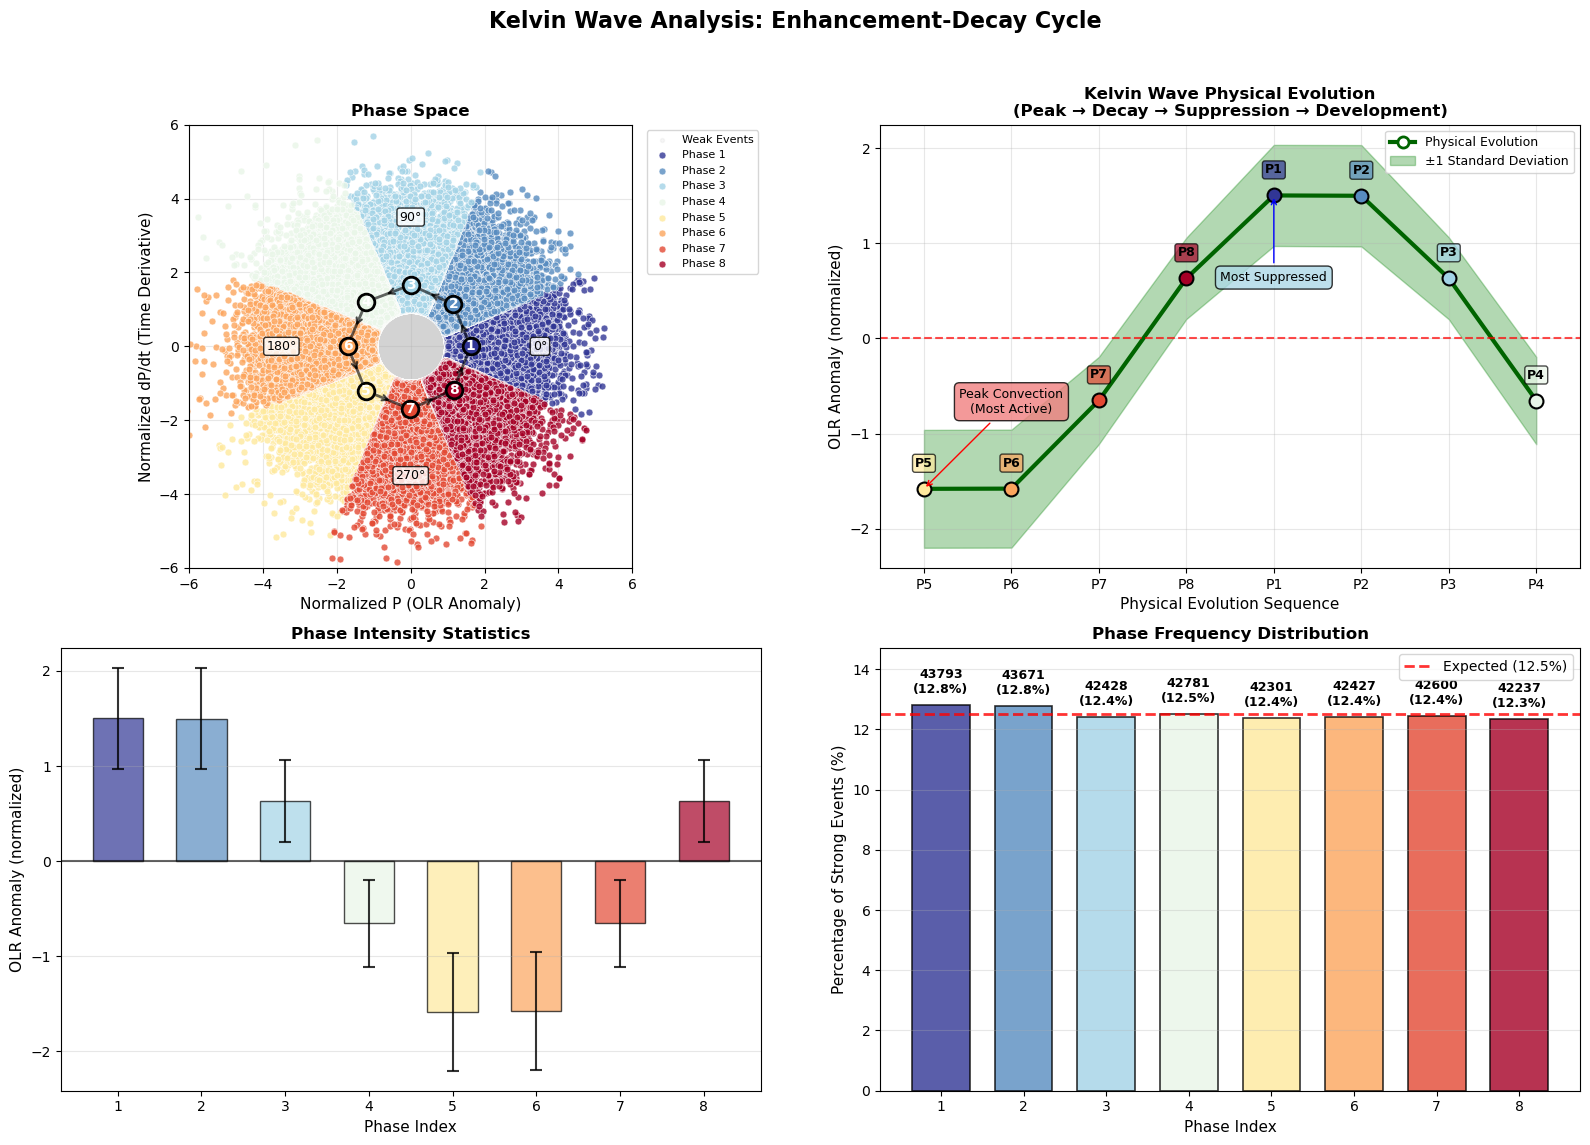

In [31]:
# ================= 主函数 =================
if __name__ == "__main__":
    print("Loading data...")
    ds = xr.open_dataset('I:/olr.day.mean.nc').olr.sel(
        time=slice('1998-01-01', '2009-12-31'),
        lat=slice(15, -15),
    ).sortby('lat')

    wave_filter = wkf.WaveFilter()
    n_phases = 8
    start_angle_deg = 0  # 控制第一位相显示方向

    print(f"Calculating phase and amplitude with {n_phases} phases...")
    phase_results = create_kelvin_phase_space(ds, wave_filter, n_phase=n_phases, start_angle_deg=start_angle_deg)

    print_phase_summary(phase_results)
    print_angle_phase_mapping(phase_results)

    print("Generating Kelvin wave core analysis...")
    fig, axes = plot_kelvin_wave_core_analysis(phase_results, start_angle_deg=start_angle_deg)

    plt.show()